In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import timeit
from copy import deepcopy

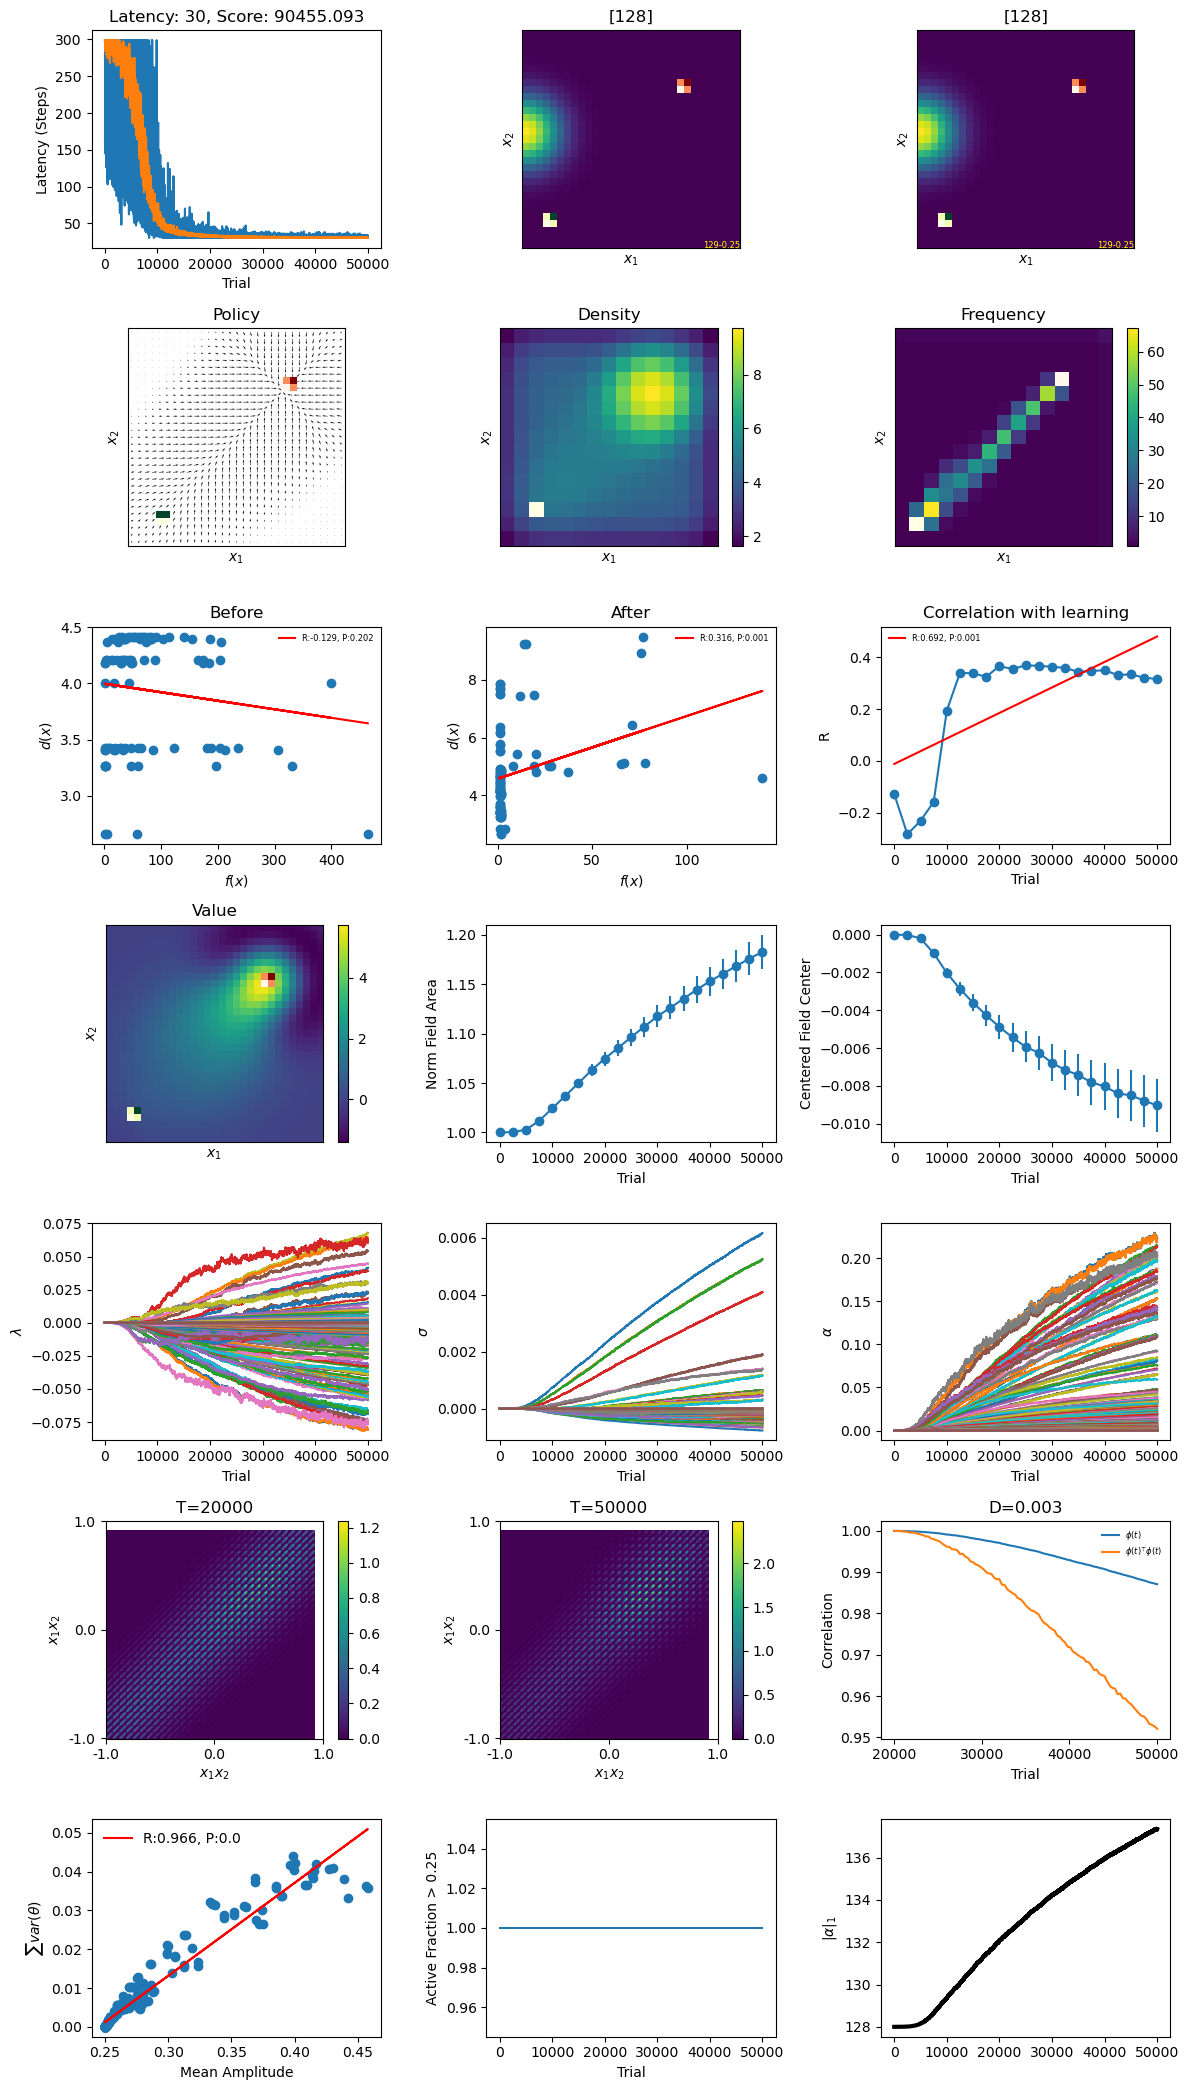

In [2]:
load_expt = "./data/2D_td_online_0.0ba_0.0ns_0p_256n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_4a_0s_50000e_5rmax_0.05rsz"
[logparams, latencys,cum_rewards, allcoords] = saveload(load_expt, 1, 'load')
plot_analysis(logparams, latencys, allcoords, stable_perf=20000)
episodes = len(latencys)

0.2500000654877013 0.5321044773630194


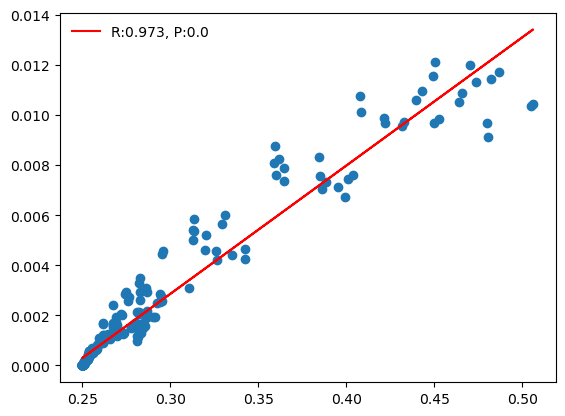

In [4]:
total_trials = 50000
stable_perf = 40000
param_delta = get_param_changes(logparams, total_trials, stable_perf)
mean_amplitude = np.mean(param_delta[2]**2,axis=0)
print(np.min(param_delta[2]**2,), np.max(param_delta[2]**2,))

param_var = get_param_variance(param_delta)
deltas = np.sum(np.std(np.array(param_var),axis=1),axis=0)
f,ax = plt.subplots()
ax.scatter(mean_amplitude, deltas)

slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_amplitude).reshape(-1), np.array(deltas).reshape(-1))
regression_line = slope * np.array(mean_amplitude).reshape(-1) + intercept
ax.plot(np.array(mean_amplitude).reshape(-1), regression_line, color='red', label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
ax.legend(frameon=False)

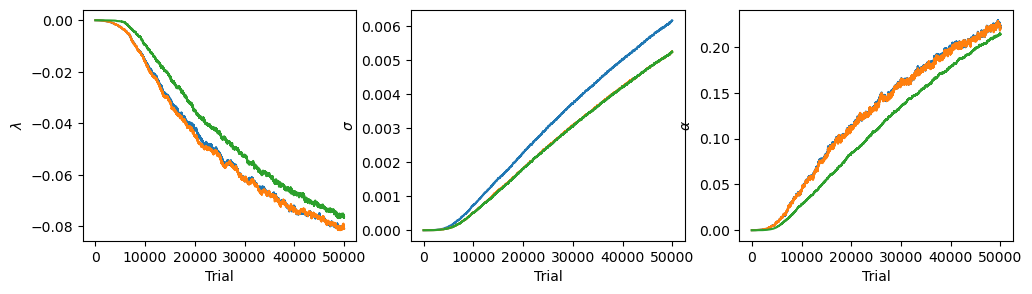

In [10]:
def get_param_changes(logparams, total_trials, stable_perf=0):

    lambdas = []
    sigmas = []
    alphas = []
    values = []
    policies = []
    episodes = np.arange(stable_perf, total_trials)
    for e in episodes:
        lambdas.append(logparams[e][0])
        sigmas.append(logparams[e][1])
        alphas.append(logparams[e][2])
        values.append(logparams[e][4])
        policies.append(logparams[e][3])
    lambdas = np.array(lambdas)
    sigmas = np.array(sigmas)
    alphas = np.array(alphas)
    policies = np.array(policies)
    values = np.array(values)
    return [lambdas, sigmas, alphas, policies, values]

def plot_param_variance(param_change, total_trials,num=10,axs=None):
    if axs is None:
        f,axs = plt.subplots(nrows=1, ncols=3)
    [lambdas, sigmas, alphas, policies, values] = param_change
    episodes = np.arange(0, total_trials)

    labels = [r'$\lambda$', r'$\sigma$',r'$\alpha$']
    for i, param in enumerate([lambdas, sigmas, alphas]):
        if i == 0:
            delta_lambdas = np.linalg.norm(param,ord=2,axis=2)
            variances = delta_lambdas - delta_lambdas[0]
        elif i == 1:
            delta_sigmas = np.sum(np.diagonal(param,axis1=-2, axis2=-1),axis=-1)
            variances = delta_sigmas - delta_sigmas[0]
        elif i == 2:
            variances = param - param[0]

        top_indices = np.argsort(np.std(variances,axis=0))[-num:][::-1]
        # print(top_indices)
        for n in top_indices:
            axs[i].plot(episodes, variances[:,n])
            # axs[i].plot(episodes, )

        axs[i].set_xlabel('Trial')
        axs[i].set_ylabel(labels[i])

        
f,ax = plt.subplots(1,3,figsize=(12,3))
param_delta = get_param_changes(logparams, total_trials)
plot_param_variance(param_delta, total_trials,num=3,axs=ax)

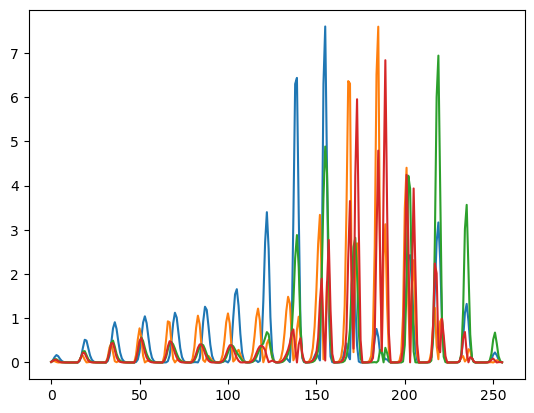

In [31]:
plt.plot(param_delta[3][-1]**2)

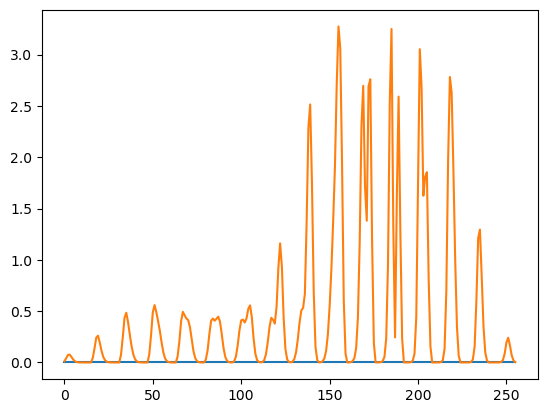

In [32]:
plt.plot(0.25* np.sum(param_delta[3][-1],axis=1)**2)
plt.plot(0.25* np.sum(param_delta[3][-1]**2,axis=1))

In [29]:
param_delta[3][-1].shape

(256, 4)

In [14]:
param_delta = get_param_changes(logparams, total_trials)

In [21]:
def normalize_values(x):
    maxval = np.max(x)
    minval = np.min(x)
    return (x-minval)/(maxval-minval)

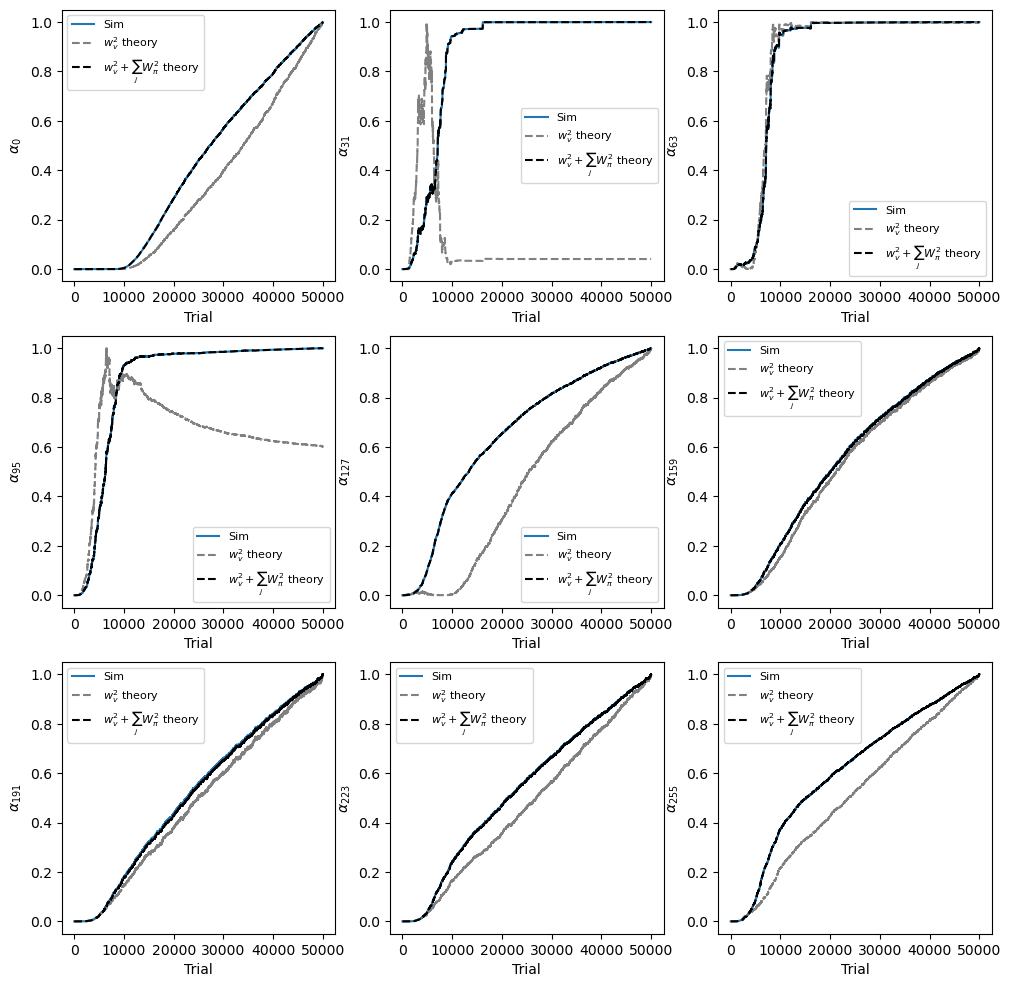

In [54]:
f,ax = plt.subplots(3,3,figsize=(12,12))
ax = ax.flatten()
for i,n in enumerate(np.linspace(0, param_delta[2].shape[1]-1,9, dtype=int)):
    sim = param_delta[2][:,n]
    half_theory = param_delta[4][:,n,0]**2
    # theory = param_delta[4][:,n,0]**2 + 0.25* np.sum(param_delta[3][:,n],axis=1)**2
    theory2 = param_delta[4][:,n,0]**2 + np.sum(param_delta[3][:,n]**2,axis=1)

    df = np.round(np.array([np.sum(abs(normalize_values(sim) - normalize_values(half_theory))), np.sum(abs(normalize_values(sim) - normalize_values(theory))), np.sum(abs(normalize_values(sim) - normalize_values(theory2)))]),3)

    ax[i].plot(normalize_values(sim), color='tab:blue')
    ax[i].plot(normalize_values(half_theory), linestyle='--', color='gray')
    # ax[i].plot(normalize_values(theory), linestyle='--', color='gray')
    ax[i].plot(normalize_values(theory2), linestyle='--', color='k')
    # ax[i].set_title(df)

    ax[i].set_xlabel('Trial')
    ax[i].set_ylabel(f'$\\alpha_{{{n}}}$')

    ax[i].plot([],[],label='Sim',color='tab:blue')
    ax[i].plot([],[],linestyle='--', label='$w_v^2$ theory',color='gray')
    # ax[i].plot([],[], linestyle='--',label='$w_v^2 + W_\pi^2$ theory',color='gray')
    ax[i].plot([],[], linestyle='--',label='$w_v^2 + \sum_j W_\pi^2$ theory',color='k')
    ax[i].legend(fontsize=8)